# Titanic classification task

In [14]:
using Pkg
Pkg.activate(".")

using Revise
using DecisionTrees
using ProgressMeter
using Statistics
using DataFrames
using CSV
using JLD
using Plots
pyplot()

  Activating project at `d:\projects_julia\jul-project\DecisionTrees\examples`

Plots.PyPlotBackend()

## Data loading and preprocessing

Load training data from CSV file to matrix.

In [15]:
train_path = "../assets/train.csv"
data = csv_to_matrix(train_path)

891×12 Matrix{Any}:
   1  0  3  …  missing           "S"
   2  1  1     "C85"   "C"
   3  1  3     missing           "S"
   4  1  1     "C123"  "S"
   5  0  3     missing           "S"
   6  0  3  …  missing           "Q"
   7  0  1     "E46"   "S"
   8  0  3     missing           "S"
   9  1  3     missing           "S"
  10  1  2     missing           "C"
   ⋮        ⋱  ⋮                 
 883  0  3     missing           "S"
 884  0  2     missing           "S"
 885  0  3     missing           "S"
 886  0  3  …  missing           "Q"
 887  0  2     missing           "S"
 888  1  1     "B42"   "S"
 889  0  3     missing           "S"
 890  1  1     "C148"  "C"
 891  0  3  …  missing           "Q"

Select columns from data matrix corresponding to 
`Passenger class`, `Name`, `Sex`, `Age`, `Number of siblings / spouses`, 
`Number of parents / children`, `Fare`, `Cabin`, `Embarked` and using 
function `reformat_data` change their type, set missing values, 
producing data matrix `X`.

In [16]:
data_X = data[:, [3, 4, 5, 6, 7, 8, 10, 11, 12]]
X = reformat_data(
    data_X, 
    [String, String, String, Int, Int, Int, Float32, String, String],
    ["missing", "missing", "missing", -1, -1, -1, -1.0, "missing", "missing"]
)

891×9 Matrix{Any}:
 "3"  …  22  1  0   7.25    "missing"  "S"
 "1"     38  1  0  71.2833  "C85"      "C"
 "3"     26  0  0   7.925   "missing"  "S"
 "1"     35  1  0  53.1     "C123"     "S"
 "3"     35  0  0   8.05    "missing"  "S"
 "3"  …  -1  0  0   8.4583  "missing"  "Q"
 "1"     54  0  0  51.8625  "E46"      "S"
 "3"      2  3  1  21.075   "missing"  "S"
 "3"     27  0  2  11.1333  "missing"  "S"
 "2"     14  1  0  30.0708  "missing"  "C"
 ⋮    ⋱         ⋮                      
 "3"     22  0  0  10.5167  "missing"  "S"
 "2"     28  0  0  10.5     "missing"  "S"
 "3"     25  0  0   7.05    "missing"  "S"
 "3"  …  39  0  5  29.125   "missing"  "Q"
 "2"     27  0  0  13.0     "missing"  "S"
 "1"     19  0  0  30.0     "B42"      "S"
 "3"     -1  1  2  23.45    "missing"  "S"
 "1"     26  0  0  30.0     "C148"     "C"
 "3"  …  32  0  0   7.75    "missing"  "Q"

Select `Survived` column, reformat it, and save it to label vector `Y`.

In [17]:
data_Y = data[:, [2]]
Y = vec(reformat_data(data_Y, [Int], [-1]))

891-element Vector{Any}:
 0
 1
 1
 1
 0
 0
 0
 0
 1
 1
 ⋮
 0
 0
 0
 0
 0
 1
 0
 1
 0

Do the same with testing dataset:

In [18]:
test_path = "../assets/test.csv"
data = csv_to_matrix(test_path)
data_X = data[:, [3, 4, 5, 6, 7, 8, 10, 11, 12] .- 1]
X_TEST = reformat_data(
    data_X, 
    [String, String, String, Int, Int, Int, Float32, String, String],
    ["missing", "missing", "missing", -1, -1, -1, -1.0, "missing", "missing"]
)

418×9 Matrix{Any}:
 "3"  …  34  0  0    7.8292  "missing"  "Q"
 "3"     47  1  0    7.0     "missing"  "S"
 "2"     62  0  0    9.6875  "missing"  "Q"
 "3"     27  0  0    8.6625  "missing"  "S"
 "3"     22  1  1   12.2875  "missing"  "S"
 "3"  …  14  0  0    9.225   "missing"  "S"
 "3"     30  0  0    7.6292  "missing"  "Q"
 "2"     26  1  1   29.0     "missing"  "S"
 "3"     18  0  0    7.2292  "missing"  "C"
 "3"     21  2  0   24.15    "missing"  "S"
 ⋮    ⋱         ⋮                       
 "3"      3  1  1   13.775   "missing"  "S"
 "3"  …  -1  0  0    7.75    "missing"  "Q"
 "1"     37  1  0   90.0     "C78"      "Q"
 "3"     28  0  0    7.775   "missing"  "S"
 "3"     -1  0  0    8.05    "missing"  "S"
 "1"     39  0  0  108.9     "C105"     "C"
 "3"  …  38  0  0    7.25    "missing"  "S"
 "3"     -1  0  0    8.05    "missing"  "S"
 "3"     -1  1  1   22.3583  "missing"  "C"

## Decision tree

Optimal hyperparameters `depth` and `attribute_count` are found by grid search.
All possible values for `attribute_count` are $\{1, \dots, 9\}$.
The upper bound on `depth` can be found by searching for minimal depth 
which sets training error to 0.0:

In [16]:
d = 0
train_error = 1.0
while train_error > 0.0
    dt = DecisionTree()
    learn!(dt, X, Y; depth=d, attribute_count=9)
    Y_ = evaluate(dt, X)
    train_error = mean(Y .!= Y_)
    d += 1
end
println("Upper depth bound: $(d-1)")

Upper depth bound: 21


Therefore the possible `depth` values are $\{0, \dots, 21\}$.

Now, it is finally possible to conduct grid search with cross-validation:

*Warning: Runtime around 55 minutes!*

In [65]:
N = 25
depths = 1:21
attribute_counts = 1:9
errors = zeros(21, 9)

for n in 1:N
    X_shf, Y_shf = shuffle_data(X, Y)
    X_train, Y_train, X_test, Y_test = split_data(X_shf, Y_shf)
    for d in depths
        for ac in attribute_counts
            dt = DecisionTree()
            learn!(dt, X_train, Y_train; depth=d, attribute_count=ac)
            Y_test_ = evaluate(dt, X_test)
            errors[d, ac] += mean(Y_test .!= Y_test_)
        end
    end
end
errors = errors ./ N;

In [97]:
save("../assets/dt_errors.jld", "errors", errors)

In [60]:
errors = load("../assets/dt_errors.jld", "errors");

Resulting testing errors for each parameter pair can be seen below:

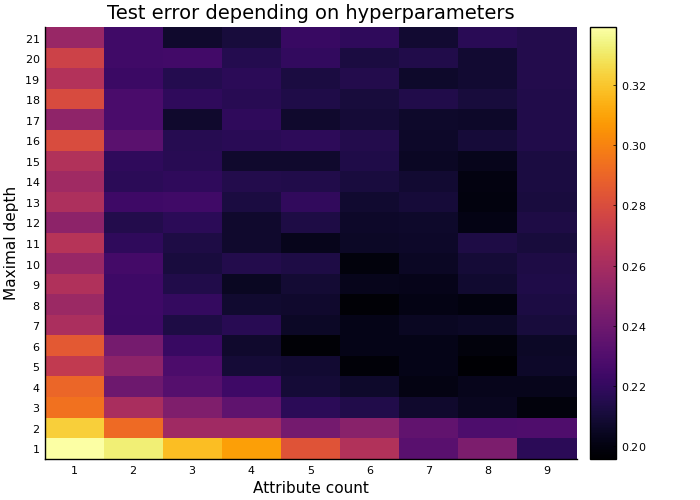

In [61]:
heatmap(
    errors;
    title="Test error depending on hyperparameters",
    xlabel="Attribute count",
    xticks=1:9,
    ylabel="Maximal depth",
    yticks=1:21,
    size=(700, 500)
)

In [63]:
best_d, best_ac = Tuple(argmin(errors)) # 5, 8
println("Best depth: $(best_d)")
println("Best attribute count: $(best_ac)")

Best depth: 5
Best attribute count: 8


The optimal hyperparameters according to grid search are 
`depth = 5` and `attribute_count = 8`.
Now, we can learn all decision tree using these hyperparameters with complete
training dataset, then classify testing dataset and save results into file.

In [92]:
dt = DecisionTree()
learn!(dt, X, Y; depth=best_d, attribute_count=best_ac)

In [93]:
Y_TEST = evaluate(dt, X_TEST)

418-element Vector{Int64}:
 0
 0
 0
 0
 1
 0
 1
 0
 1
 0
 ⋮
 0
 1
 1
 1
 0
 1
 0
 0
 0

In [94]:
passenger_id = collect(892:892+418-1)
df = DataFrame(PassengerId=passenger_id, Survived=Y_TEST)
CSV.write("../assets/result_dt.csv", df)

"../assets/result_dt.csv"

#### Kaggle score: $0.76315$

*Which corresponds to test error rate of $0.23685$.*

## Random forest

For classification using random forest we will try two approaches - 
with and witout bagging.



### Without bagging

This approach corresponds to simply using several trees with optimal 
`depth` and `attribute_count` were already found.
The only hyperparameter to search for is `size` of random forest.

*Warning: Runtime around 30 minutes!*

In [114]:
N = 10
sizes = [1, 3, 5, 11, 17, 33, 65, 129]
errors = zeros(length(sizes))

for n in 1:N
    X_shf, Y_shf = shuffle_data(X, Y)
    X_train, Y_train, X_test, Y_test = split_data(X_shf, Y_shf)
    for (i, s) in enumerate(sizes)
        rf = RandomForest(s)
        learn!(rf, X_train, Y_train; depth=5, attribute_count=8, show_progress=false)
        Y_test_ = evaluate(rf, X_test)
        errors[i] += mean(Y_test .!= Y_test_)
    end
end
errors = errors ./ N;

In [75]:
save("../assets/rf_size_errors.jld", "errors", errors)

In [76]:
errors = load("../assets/rf_size_errors.jld", "errors");

Resulting testing errors are diplayed below:

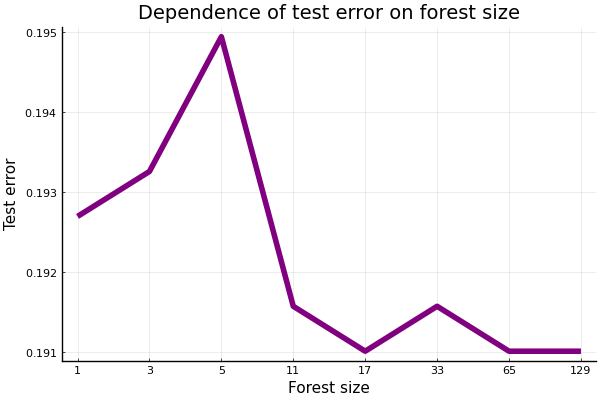

In [77]:
str_sizes = string.([1, 3, 5, 11, 17, 33, 65, 129])
plot(
    str_sizes, errors;
    title="Dependence of test error on forest size",
    xlabel="Forest size",
    ylabel="Test error",
    linewidth=4,
    linecolor=:purple,
    legend=false,
)

In [67]:
best_s = sizes[argmin(errors)]
println("Best forest size: $(best_s)")

Best forest size: 65


The optimal forest `size` is 65.

Now, we can solve Titanic classification task using decision forest without
bagging in a similar way as before.

In [121]:
rf = RandomForest(best_s)
learn!(rf, X, Y; depth=5, attribute_count=8, show_progress=false)
Y_TEST = evaluate(rf, X_TEST)

418-element Vector{Int64}:
 0
 0
 0
 0
 1
 0
 1
 0
 1
 0
 ⋮
 0
 1
 1
 1
 0
 1
 0
 0
 0

In [122]:
passenger_id = collect(892:892+418-1)
df = DataFrame(PassengerId=passenger_id, Survived=Y_TEST)
CSV.write("../assets/result_rf_nobag.csv", df)

"../assets/result_rf_nobag.csv"

#### Kaggle score: $0.75119$

*Which corresponds to test error rate of $0.24881$.*



### With bagging

Trees should be learned to maximal depth.
The forest size is taken from previous task.
Find optimal `attribute_count`.

*Warning: Runtime around 66 minutes!*

In [6]:
N = 10
attribute_counts = 1:9
errors = zeros(9)

for n in 1:N
    X_shf, Y_shf = shuffle_data(X, Y)
    X_train, Y_train, X_test, Y_test = split_data(X_shf, Y_shf)
    for ac in attribute_counts
        rf = RandomForest(65)
        learn!(rf, X_train, Y_train; depth=21, attribute_count=ac, bagging=true, 
               show_progress=false)
        Y_test_ = evaluate(rf, X_test)
        errors[ac] += mean(Y_test .!= Y_test_)
    end
end
errors = errors ./ N;

In [80]:
save("../assets/rf_ac_errors.jld", "errors", errors)

In [81]:
errors = load("../assets/rf_ac_errors.jld", "errors");

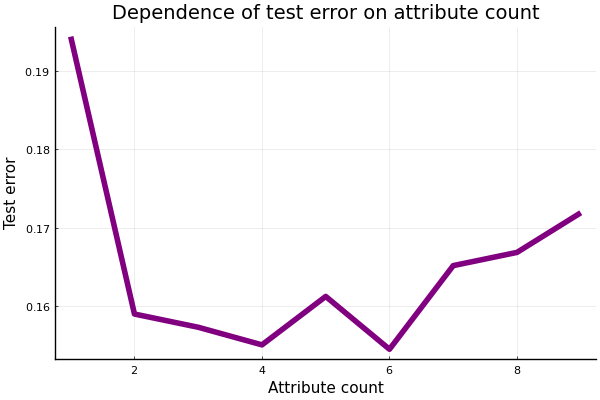

In [82]:
attribute_counts = 1:9
plot(
    attribute_counts, errors;
    title="Dependence of test error on attribute count",
    xlabel="Attribute count",
    ylabel="Test error",
    linewidth=4,
    linecolor=:purple,
    legend=false,
)

In [72]:
best_ac = attribute_counts[argmin(errors)]
println("Best attribute count: $(best_ac)")

Best attribute count: 6


In [12]:
rf = RandomForest(65)
learn!(rf, X, Y; depth=21, attribute_count=best_ac, bagging=true,
       show_progress=false)
Y_TEST = evaluate(rf, X_TEST)

418-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 ⋮
 1
 1
 1
 0
 0
 1
 0
 0
 0

In [13]:
passenger_id = collect(892:892+418-1)
df = DataFrame(PassengerId=passenger_id, Survived=Y_TEST)
CSV.write("../assets/result_rf_bag.csv", df)

"../assets/result_rf_bag.csv"

#### Kaggle score: $0.75837$

*Which corresponds to test error rate of $0.24163$.*